# Определение возраста покупателей по фотографии

**Задача:** сделать систему оценки возраста по фотографиям покупателей в прикассовой зоне.

**Данные:**
7591 фотография + возраст

Нужно исследовать данные, но обучить модель на сервере - создать скрипт для обучения на `Keras` с использованием `resnet50`.

В качестве метрики качества используем `MAE`.



## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.shape

(7591, 2)

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

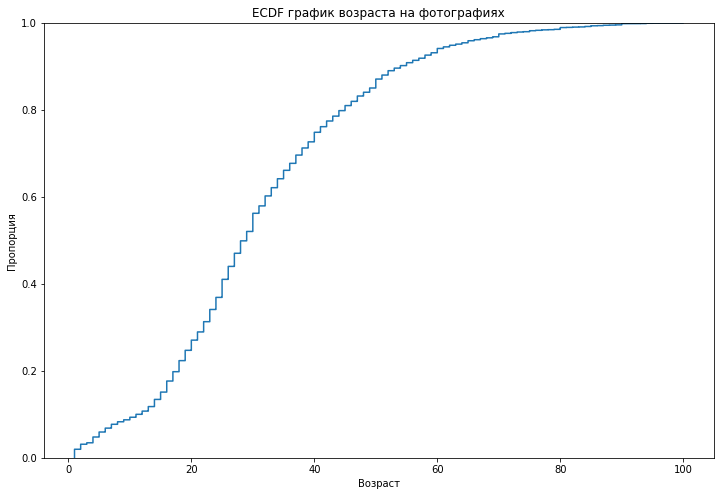

In [6]:
plt.figure(figsize=(12,8))
sns.ecdfplot(data=labels,x='real_age')
plt.title('ECDF график возраста на фотографиях')
plt.xlabel('Возраст')
plt.ylabel('Пропорция')
plt.show()

**Вывод:**
* Первые 10% составляет возраст от 0 до ~15. 
* Есть резкие скачки на ~25, ~40, ~50 и, видимо, на целых числах.
* Остальные возраста распределены более равномерно

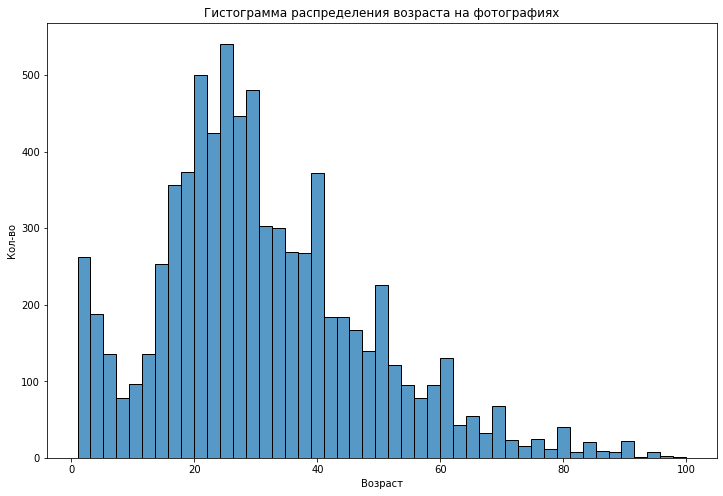

In [7]:
plt.figure(figsize=(12,8))
sns.histplot(data=labels,x='real_age')
plt.title('Гистограмма распределения возраста на фотографиях')
plt.xlabel('Возраст')
plt.ylabel('Кол-во')
plt.show()

**Вывод:**
* Видим тоже самое.
* От 0 до 10 лет идет спад, а затем рост.
* Ровных возрастов больше, чем неровных.

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 


Found 7591 validated image filenames.


In [9]:
features, target = next(train_gen_flow)

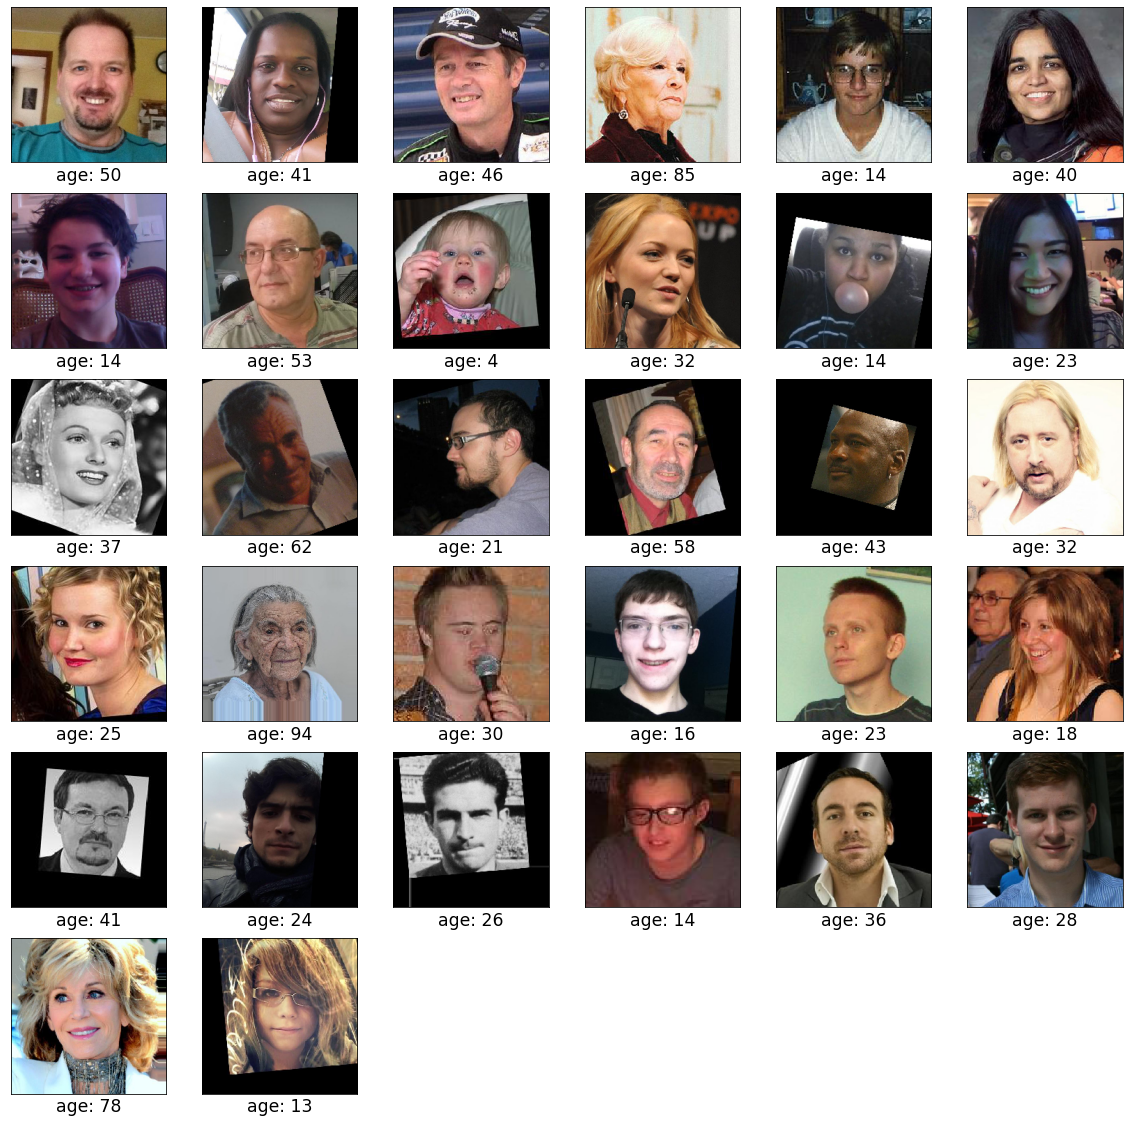

In [10]:
fig = plt.figure(figsize=(20, 20))

columns = 6
rows = round(len(target)/columns)+1

for i,ft in enumerate(zip(features,target)):
    image,age = ft[0],ft[1]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(image)
    plt.xlabel('age: '+str(age),fontsize='xx-large')
    plt.xticks([], [])
    plt.yticks([], [])

    
plt.show()

**Описание фотографий:**
* Есть чернобелые и цветные фотографии
* Есть обрезанные
* Повернутые
* Некоторые фотографии из фильмов
* Контрастность, кажется, неравномерна
* Четкость и качество фотографий тоже отличается
* В некоторых фотографиях край "смазан", т.е. пиксели границы фотографии продолжаются до границы (бабушка 94 лет в 3 ряду снизу)

## Обучение модели

Дальше идет код обучения модели и логи.

```python
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

import pandas as pd

# optimizer = Adam(lr=0.001) 


def load_train(path):
    
    labels = pd.read_csv(path+'/labels.csv')
    
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.2,
                                      horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return  train_gen_flow

def load_test(path):
    
    labels = pd.read_csv(path+'/labels.csv')
    
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.2)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 

    return  test_gen_flow


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        # weights='imagenet',
                    include_top=False)
    # backbone.trainable = False
    

    model = Sequential()

    model.add(backbone)

    model.add(GlobalAveragePooling2D())
    model.add(Dense(100,activation='relu'))
    model.add(Dense(1,activation='relu'))
    model.compile(optimizer=Adam(lr=0.0001), loss='mse',
                  metrics=['mae'])    

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    callback = EarlyStopping(monitor='loss', patience=1)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              callbacks=[callback],
              verbose=2)
    
    return model

```

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/10
190/190 - 50s - loss: 313.3442 - mae: 12.4185 - val_loss: 440.8286 - val_mae: 15.7996
Epoch 2/10
190/190 - 41s - loss: 78.2800 - mae: 6.6818 - val_loss: 470.4760 - val_mae: 16.2454
Epoch 3/10
190/190 - 41s - loss: 47.9902 - mae: 5.3544 - val_loss: 172.4212 - val_mae: 10.0259
Epoch 4/10
190/190 - 41s - loss: 34.6025 - mae: 4.4638 - val_loss: 99.0320 - val_mae: 7.7079
Epoch 5/10
190/190 - 41s - loss: 26.0785 - mae: 3.9149 - val_loss: 71.4200 - val_mae: 6.3695
Epoch 6/10
190/190 - 40s - loss: 19.1124 - mae: 3.3553 - val_loss: 68.7041 - val_mae: 6.0896
Epoch 7/10
190/190 - 41s - loss: 15.2349 - mae: 2.9499 - val_loss: 71.5450 - val_mae: 6.2146
Epoch 8/10
190/190 - 40s - loss: 12.2775 - mae: 2.6687 - val_loss: 59.9155 - val_mae: 5.8228
Epoch 9/10
190/190 - 41s - loss: 10.4692 - mae: 2.4530 - val_loss: 66.8128 - val_mae: 5.9863
Epoch 10/10
190/190 - 41s - loss: 9.3530 - mae: 2.2927 - val_loss: 70.9079 - val_mae: 6.4434
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 70.9079 - mae: 6.4434
Test MAE: 6.4434
```

## Анализ обученной модели

Датасет состоит из `7591` фотографий.  
Средний возраст 30 лет, но распределение не нормальное. 

* Сеть состоит из:
    * `resnet50`
    * `GlobalAveragePooling2D()`
    * `Dense` `100` с `ReLu`  
    * `Dense` `1` с `ReLu`  
    
Оптимизатор: `Adam` с `learning_rate = 0.0001`.  
Функция потерь: `MSE`  
Метрика: `MAE`  
Кол-во эпох: `10`  
 
Модель достигла `MAE: 6.4434` на тестовых данных.


Результат удовлетворительный. `MAE: 6.4434` говорит, что модель в среднем будет ошибаться на 6 лет. Правильно подобрав бины возраста, можно уменьшить влияние ошибки на бизнес результаты. Например, установив категорию от 0 до 18 лет, то ошибка модели не перебросит клиента в другую возрастную категорию в промежутке, условно, от 0 до 12 лет.